# **1.Time Benchmark**

In [ ]:
import pandas as pd

df = pd.read_csv("../../Data/AAM/results_benchmark/mapping_times.csv", index_col=0)
df.rename(columns={"Unnamed: 0": "dataset"}, inplace=True)
df = df / 60
df["Number of Reactions"] = [273, 382, 3000, 1758, 491]
df

In [ ]:
import copy

df.rename(
    columns={
        "rxn_mapper": r"$\texttt{RXNMapper}$",
        "graphormer": r"$\texttt{GraphormerMapper}$",
        "local_mapper": r"$\texttt{LocalMapper}$",
        "rdt": r"$\texttt{RDT}$",
    },
    inplace=True,
)

df_time = copy.deepcopy(df)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from typing import List, Optional


def _calculate_stats(sub_df: pd.DataFrame, column: str, logarit=True) -> tuple:
    """
    Helper function to calculate the average and standard deviation of reaction times.

    Parameters:
    - sub_df (pd.DataFrame): Subset of the main DataFrame.
    - column (str): Name of the column for which to calculate statistics.

    Returns:
    - tuple: A tuple containing the average and standard deviation.
    """
    if logarit:
        avg = -np.log((sub_df[column].sum()) / sub_df["Number of Reactions"].sum())
        std = np.sqrt(
            np.sum((np.log(sub_df[column]) / sub_df["Number of Reactions"] - avg) ** 2)
            / sub_df["Number of Reactions"].sum()
        )
    else:
        avg = sub_df[column].sum() / sub_df["Number of Reactions"].sum()
        std = np.sqrt(
            np.sum((sub_df[column] / sub_df["Number of Reactions"] - avg) ** 2)
            / sub_df["Number of Reactions"].sum()
        )
    return avg, std


def plot_reaction_times(df: pd.DataFrame, ax: Axes) -> None:
    """
    Plot average reaction times for different datasets with error bars.

    This function visualizes the average reaction times for 'All', 'Biochemical',
    and 'Chemical' datasets, using error bars to indicate variability. It expects
    a DataFrame with reaction times across these categories and an Axes object
    to draw the plot.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the reaction time data.
      It should have columns for each mapper (e.g., 'Mapper1', 'Mapper2', etc.)
      and a 'Number of Reactions' column for normalization.
    - ax (matplotlib.axes.Axes): Matplotlib Axes object where the plot will be drawn.

    Returns:
    - None: The function directly modifies the provided Axes object with the plot.

    Notes:
    - The function uses LaTeX rendering for text, which requires a LaTeX system installed.
    - It sets the y-axis limit based on assumed data range, which may need adjustment.
    """
    # Enable LaTeX rendering in matplotlib
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"\usepackage{amsmath}")
    sns.set(style="darkgrid")  # Correct style for background grid

    # Define colors for better differentiation in the plot
    colors = ["#4c92c3", "#ffdd57", "#ff6f61"]

    # Define bar width and positions
    bar_width = 0.25
    x = np.arange(len(df.columns[:-1]))  # Position indexes for mappers

    # Plot each category for mappers with error bars
    for i, mapper in enumerate(df.columns[:-1]):
        all_avg, all_std = _calculate_stats(df, mapper)
        bio_avg, bio_std = _calculate_stats(df.iloc[:2], mapper)
        chem_avg, chem_std = _calculate_stats(df.iloc[2:], mapper)

        # Plotting bars for each category on the provided ax object
        ax.bar(
            x[i] - bar_width,
            all_avg,
            width=bar_width,
            color=colors[0],
            label=r"$\textit{All dataset}$" if i == 0 else "",
            yerr=all_std,
            capsize=5,
        )
        ax.bar(
            x[i],
            bio_avg,
            width=bar_width,
            color=colors[1],
            label=r"$\textit{Biochemical dataset}$" if i == 0 else "",
            yerr=bio_std,
            capsize=5,
        )
        ax.bar(
            x[i] + bar_width,
            chem_avg,
            width=bar_width,
            color=colors[2],
            label=r"$\textit{Chemical dataset}$" if i == 0 else "",
            yerr=chem_std,
            capsize=5,
        )

        # Add text labels for average values above each bar
        ax.text(
            x[i] - bar_width,
            all_avg,
            f"{all_avg:.2f}",
            ha="center",
            va="bottom",
            color="black",
            fontsize=18,
        )
        ax.text(
            x[i],
            bio_avg,
            f"{bio_avg:.2f}",
            ha="center",
            va="bottom",
            color="black",
            fontsize=18,
        )
        ax.text(
            x[i] + bar_width,
            chem_avg,
            f"{chem_avg:.2f}",
            ha="center",
            va="bottom",
            color="black",
            fontsize=18,
        )

    # Set labels, title, and ticks for the plot
    ax.set_ylabel(r"$-\log(minutes)$", fontsize=24, weight="bold", color="black")
    ax.set_xticks(x)
    ax.set_xticklabels(df.columns[:-1], fontsize=20, weight="bold", color="black")
    ax.set_title(r"A. Processing time benchmarking", fontsize=28, weight="bold")
    ax.tick_params(axis="y", labelsize=18, labelcolor="black")
    ax.legend(fontsize=20, loc="upper right", frameon=True, edgecolor="black")
    # ax.set_ylim(0, 7)  # Adjust this limit based on your data range

In [ ]:
for i, mapper in enumerate(df_time.columns[:-1]):
    all_avg, all_std = _calculate_stats(df_time, mapper, logarit=False)
    bio_avg, bio_std = _calculate_stats(df_time.iloc[:2], mapper)
    chem_avg, chem_std = _calculate_stats(df_time.iloc[2:], mapper)

In [ ]:
all_std

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# from _analysis._aam_analysis import plot_reaction_times

plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{amsmath}")
sns.set_theme(style="darkgrid")
# Example of how to use the modified function in a subplot


# Example of how to use the modified function in a subplot
fig, ax = plt.subplots(figsize=(12, 6))

plot_reaction_times(df_time, ax)

# plt.tight_layout()
# fig.savefig("./fig/aam_time_benchmark.pdf", dpi=600, bbox_inches="tight", pad_inches=0)
plt.show()

In [ ]:
np.log(6)

# **2. Success rate Benchmark**

In [ ]:
import re


def calculate_mapping_failures(data):
    """
    Calculates the number of failed mappings based on the absence of atom maps in the reaction data.
    Args:
    data (list of dicts): A list of dictionaries where each dictionary represents reaction data.

    Returns:
    dict: A dictionary containing the number of fails and success rates for each mapper type.
    """

    # Keys to evaluate
    keys_to_check = ["rxn_mapper", "graphormer", "local_mapper", "rdt"]

    # Initialize results dictionary to store fails and successes
    results = {key: {"fails": 0, "successes": 0} for key in keys_to_check}

    # Regex pattern to find atom maps
    atom_map_pattern = re.compile(r":\d+")

    # Process each dictionary in the list
    for entry in data:
        for key in keys_to_check:
            # Get the reaction data
            reaction_data = entry.get(key, "")

            # Check if the reaction contains any atom maps
            if re.search(atom_map_pattern, reaction_data):
                results[key]["successes"] += 1
            else:
                results[key]["fails"] += 1

    # Prepare aggregate results to provide total fails and success rates
    aggregate_results = {}
    for key in keys_to_check:
        total_fails = results[key]["fails"]
        total_successes = results[key]["successes"]
        total_attempts = total_fails + total_successes
        success_rate = (total_successes / total_attempts) if total_attempts > 0 else 0

        aggregate_results[f"{key}_number_fails"] = int(total_fails)
        aggregate_results[f"{key}_success_rate"] = round(
            success_rate * 100, 2
        )  # Express as percentage

    return aggregate_results

In [ ]:
import sys

sys.path.append("../../")
from syntemp.SynUtils.utils import load_database

data = load_database(
    "../../Data/AAM/results_benchmark/golden/golden_aam_reactions.json.gz"
)

In [ ]:
from syntemp.SynAAM.aam_validator import AAMValidator

results, _ = AAMValidator.validate_smiles(
    data=data,
    ground_truth_col="ground_truth",
    mapped_cols=["rxn_mapper", "graphormer", "local_mapper", "rdt"],
    check_method="RC",
    ignore_aromaticity=False,
    n_jobs=4,
    verbose=2,
    ensemble=True,
    strategies=[
        ["rxn_mapper", "graphormer", "local_mapper"],
        ["rxn_mapper", "graphormer", "local_mapper", "rdt"],
    ],
    ignore_tautomers=False,
)

In [ ]:
import sys

sys.path.append("../..")
from syntemp.SynUtils.utils import load_database

data_paths = {
    "ecoli": "../../Data/AAM/results_benchmark/ecoli/ecoli_aam_reactions.json.gz",
    "recon3d": "../../Data/AAM/results_benchmark/recon3d/recon3d_aam_reactions.json.gz",
    "uspto_3k": "../../Data/AAM/results_benchmark/uspto_3k/uspto_3k_aam_reactions.json.gz",
    "golden": "../../Data/AAM/results_benchmark/golden/golden_aam_reactions.json.gz",
    "natcomm": "../../Data/AAM/results_benchmark/natcomm/natcomm_aam_reactions.json.gz",
}

# Dictionary to hold the results for each dataset
results_dict = {}

# Process each dataset
for dataset_name, filepath in data_paths.items():
    # Load the data
    data = load_database(filepath)

    # Calculate fails and success rates
    results = calculate_mapping_failures(data)

    # Store the results
    results_dict[dataset_name] = results

# Convert the results dictionary to a DataFrame
df_results = pd.DataFrame.from_dict(results_dict, orient="index")

# Display or save the DataFrame
df_results.T

# **3. Accuracy Benchmark**

In [ ]:
import sys
import pandas as pd

sys.path.append("../..")
from syntemp.SynAAM.aam_validator import AAMValidator

In [ ]:
data_paths = {
    "ecoli": "../../Data/AAM/results_benchmark/ecoli/ecoli_aam_reactions.json.gz",
    "recon3d": "../../Data/AAM/results_benchmark/recon3d/recon3d_aam_reactions.json.gz",
    "uspto_3k": "../../Data/AAM/results_benchmark/uspto_3k/uspto_3k_aam_reactions.json.gz",
    "golden": "../../Data/AAM/results_benchmark/golden/golden_aam_reactions.json.gz",
    "natcomm": "../../Data/AAM/results_benchmark/natcomm/natcomm_aam_reactions.json.gz",
}
results_dict = {}

# Process each dataset
for dataset_name, filepath in data_paths.items():
    # Load the data
    data = load_database(filepath)

    # Calculate fails and success rates
    results, _ = AAMValidator.validate_smiles(
        data=data,
        ground_truth_col="ground_truth",
        mapped_cols=["rxn_mapper", "graphormer", "local_mapper", "rdt"],
        check_method="RC",
        ignore_aromaticity=False,
        n_jobs=4,
        verbose=2,
        ensemble=True,
        strategies=[
            ["rxn_mapper", "graphormer", "local_mapper"],
            ["rxn_mapper", "graphormer", "local_mapper", "rdt"],
        ],
        ignore_tautomers=False,
    )

    # Store the results
    results_dict[dataset_name] = results

bio = []
for dataset_name, filepath in data_paths.items():
    # Load the dataset
    single = load_database(filepath)

    # Extend the bio list if the dataset is either 'ecoli' or 'recon3d'
    if dataset_name in ["ecoli", "recon3d"]:
        bio.extend(single)
results, _ = AAMValidator.validate_smiles(
    data=bio,
    ground_truth_col="ground_truth",
    mapped_cols=["rxn_mapper", "graphormer", "local_mapper", "rdt"],
    check_method="RC",
    ignore_aromaticity=False,
    n_jobs=4,
    verbose=2,
    ensemble=True,
    strategies=[
        ["rxn_mapper", "graphormer", "local_mapper"],
        ["rxn_mapper", "graphormer", "local_mapper", "rdt"],
    ],
    ignore_tautomers=False,
)
results_dict["Biochemical"] = results


chem = []
for dataset_name, filepath in data_paths.items():
    # Load the dataset
    single = load_database(filepath)

    # Extend the bio list if the dataset is either 'ecoli' or 'recon3d'
    if dataset_name in ["golden", "natcomm", "uspto_3k"]:
        chem.extend(single)

results, _ = AAMValidator.validate_smiles(
    data=chem,
    ground_truth_col="ground_truth",
    mapped_cols=["rxn_mapper", "graphormer", "local_mapper", "rdt"],
    check_method="RC",
    ignore_aromaticity=False,
    n_jobs=4,
    verbose=2,
    ensemble=True,
    strategies=[
        ["rxn_mapper", "graphormer", "local_mapper"],
        ["rxn_mapper", "graphormer", "local_mapper", "rdt"],
    ],
    ignore_tautomers=False,
)
results_dict["Chemical"] = results

In [ ]:
# Initialize an empty DataFrame to hold all data
import pandas as pd

final_df = pd.DataFrame()

# Process each data type
for data_type, records in results_dict.items():
    # Create a DataFrame
    df = pd.DataFrame(records)

    # Add columns for accuracy and success_rate specific to the data type
    df["accuracy_col"] = data_type + "_accuracy"
    df["success_col"] = data_type + "_success_rate"
    df["Accuracy"] = round(df["accuracy"] * 100, 2)
    df["Success Rate"] = round(df["success_rate"], 2)

    # Pivot the DataFrame
    df_pivot = df.pivot(index="mapper", columns="accuracy_col", values="Accuracy").join(
        df.pivot(index="mapper", columns="success_col", values="Success Rate")
    )

    # Merge with the final DataFrame
    if final_df.empty:
        final_df = df_pivot
    else:
        final_df = final_df.join(df_pivot)

# Reset index to make 'mapper' a column
final_df.reset_index(inplace=True)
final_df = final_df.reindex([5, 2, 3, 4, 0, 1])
final_df = final_df.reset_index(drop=True)

In [ ]:
aam_json = final_df.to_dict(orient="records")

In [ ]:
from syntemp.SynUtils.utils import save_database

save_database(aam_json, "../../Data/AAM/results_benchmark/aam_benchmark.json.gz")

## 3.0 Load results

In [2]:
import sys
import pandas as pd

sys.path.append("../../")
from syntemp.SynUtils.utils import load_database

final_df = pd.DataFrame(
    load_database("../../Data/AAM/results_benchmark/aam_benchmark.json.gz")
)

/homes/biertank/tieu/Documents/Project/TACsy/SynEco/SynTemp/Docs/Analysis/../../syntemp/SynUtils/__init__.py:3: FutureWarning: The 'SynUtils' subpackage is deprecated and will be removed in future releases. Please migrate to the 'synutility' package as soon as possible, which offers enhanced functionality. You can install it directly using pip: `pip install synutility`.
  warnings.warn(


In [3]:
final_df[
    [
        "mapper",
        "Biochemical_accuracy",
        "Biochemical_success_rate",
        "Chemical_accuracy",
        "Chemical_success_rate",
    ]
]

,mapper,Biochemical_accuracy,Biochemical_success_rate,Chemical_accuracy,Chemical_success_rate
0,rxn_mapper,58.63,100.00,90.93,100.00
1,graphormer,37.86,100.00,93.05,100.00
2,local_mapper,58.78,100.00,94.38,100.00
3,rdt,64.58,100.00,87.45,99.85
4,ensemble_1,76.10,41.53,99.47,71.23
5,ensemble_2,80.16,38.47,99.69,67.14


## 3.1 Heatmap

In [ ]:
data_visual = final_df[
    [
        "mapper",
        "ecoli_accuracy",
        "recon3d_accuracy",
        "uspto_3k_accuracy",
        "golden_accuracy",
        "natcomm_accuracy",
        "Biochemical_accuracy",
        "Chemical_accuracy",
    ]
]
data_visual.rename(
    {
        "ecoli_accuracy": "ecoli",
        "recon3d_accuracy": "recon3d",
        "uspto_3k_accuracy": "uspto_3k",
        "golden_accuracy": "golden",
        "natcomm_accuracy": "natcomm",
        "Biochemical_accuracy": "Biochemical",
        "Chemical_accuracy": "Chemical",
    },
    axis=1,
    inplace=True,
)

In [ ]:
data_visual["mapper"] = [
    r"$\texttt{RXNMapper}$",
    r"$\texttt{GraphormerMapper}$",
    r"$\texttt{LocalMapper}$",
    r"$\texttt{RDT}$",
    r"$\textit{Ensemble_1}$",
    r"$\textit{Ensemble_2}$",
]

In [ ]:
data_visual

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{amsmath}")
sns.set_theme(style="darkgrid")
from _analysis._aam_analysis import plot_heatmap

fig = plot_heatmap(data_visual, "./fig/FigS1_aam_accuracy_heatmap.pdf")
plt.show()

## 3.2 Barplot

In [5]:
df = final_df.copy()

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from typing import List, Optional


def plot_reaction_times(df: pd.DataFrame, ax: Axes) -> None:
    """
    Plot average reaction times for different datasets with error bars.

    This function visualizes the average reaction times for 'All', 'Biochemical',
    and 'Chemical' datasets, using error bars to indicate variability. It expects
    a DataFrame with reaction times across these categories and an Axes object
    to draw the plot.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the reaction time data.
      It should have columns for each mapper (e.g., 'Mapper1', 'Mapper2', etc.)
      and a 'Number of Reactions' column for normalization.
    - ax (matplotlib.axes.Axes): Matplotlib Axes object where the plot will be drawn.

    Returns:
    - None: The function directly modifies the provided Axes object with the plot.

    Notes:
    - The function uses LaTeX rendering for text, which requires a LaTeX system installed.
    - It sets the y-axis limit based on assumed data range, which may need adjustment.
    """
    # Enable LaTeX rendering in matplotlib
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"\usepackage{amsmath}")
    sns.set(style="darkgrid")  # Correct style for background grid

    # Define colors for better differentiation in the plot
    colors = ["#4c92c3", "#ffdd57", "#ff6f61"]

    # Define bar width and positions
    bar_width = 0.25
    x = np.arange(len(df.columns[:-1]))  # Position indexes for mappers

    # Plot each category for mappers with error bars
    for i, mapper in enumerate(df.columns[:-1]):
        all_avg, all_std = _calculate_stats(df, mapper)
        bio_avg, bio_std = _calculate_stats(df.iloc[:2], mapper)
        chem_avg, chem_std = _calculate_stats(df.iloc[2:], mapper)

        # Plotting bars for each category on the provided ax object
        ax.bar(
            x[i] - bar_width,
            all_avg,
            width=bar_width,
            color=colors[0],
            label=r"$\textit{All dataset}$" if i == 0 else "",
            yerr=all_std,
            capsize=5,
        )
        ax.bar(
            x[i],
            bio_avg,
            width=bar_width,
            color=colors[1],
            label=r"$\textit{Biochemical dataset}$" if i == 0 else "",
            yerr=bio_std,
            capsize=5,
        )
        ax.bar(
            x[i] + bar_width,
            chem_avg,
            width=bar_width,
            color=colors[2],
            label=r"$\textit{Chemical dataset}$" if i == 0 else "",
            yerr=chem_std,
            capsize=5,
        )

        # Add text labels for average values above each bar
        ax.text(
            x[i] - bar_width,
            all_avg + 0.05,
            f"{all_avg:.2f}",
            ha="center",
            va="bottom",
            color="black",
            fontsize=18,
        )
        ax.text(
            x[i],
            bio_avg + 0.05,
            f"{bio_avg:.2f}",
            ha="center",
            va="bottom",
            color="black",
            fontsize=18,
        )
        ax.text(
            x[i] + bar_width,
            chem_avg + 0.05,
            f"{chem_avg:.2f}",
            ha="center",
            va="bottom",
            color="black",
            fontsize=18,
        )

    # Set labels, title, and ticks for the plot
    ax.set_ylabel(
        "Average Time per Reaction (seconds)", fontsize=24, weight="bold", color="black"
    )
    ax.set_xticks(x)
    ax.set_xticklabels(
        df.columns[:-1], rotation=45, fontsize=18, weight="bold", color="black"
    )
    ax.set_title(r"A. Processing time benchmarking", fontsize=28, weight="bold")
    ax.tick_params(axis="y", labelsize=18, labelcolor="black")
    ax.legend(fontsize=20, loc="upper left", frameon=True, edgecolor="black")
    ax.set_ylim(0, 7)  # Adjust this limit based on your data range


def _calculate_stats(sub_df: pd.DataFrame, column: str) -> tuple:
    """
    Helper function to calculate the average and standard deviation of reaction times.

    Parameters:
    - sub_df (pd.DataFrame): Subset of the main DataFrame.
    - column (str): Name of the column for which to calculate statistics.

    Returns:
    - tuple: A tuple containing the average and standard deviation.
    """
    avg = sub_df[column].sum() / sub_df["Number of Reactions"].sum()
    std = np.sqrt(
        np.sum((sub_df[column] / sub_df["Number of Reactions"] - avg) ** 2)
        / sub_df["Number of Reactions"].sum()
    )
    return avg, std


def plot_heatmap(data: pd.DataFrame, save_path: Optional[str] = None) -> Figure:
    """
    Plot a heatmap to visualize accuracies across datasets and mappers with optional saving.

    This function generates a heatmap of accuracies, displaying data from different mappers
    and datasets. It assumes that the data is already prepared with 'mapper' as index.
    The plot can optionally be saved to a specified path.

    Parameters:
    - data (pd.DataFrame): A DataFrame containing the heatmap data with mappers as index
      and datasets as columns.
    - save_path (str, optional): Path to save the generated heatmap as a PDF file.
      If None, the plot is not saved.

    Returns:
    - fig (matplotlib.figure.Figure): A Matplotlib Figure object containing the heatmap.

    Raises:
    - ValueError: If the data does not contain the expected index or columns.
    """
    # Set up LaTeX rendering and seaborn theme
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"\usepackage{amsmath}")
    sns.set_theme(style="darkgrid")

    # Validate the DataFrame structure
    if "mapper" not in data.index.names:
        data = data.set_index("mapper")

    # Creating a figure object for more control
    fig, ax = plt.subplots(figsize=(16, 8))

    # Create a heatmap
    sns.heatmap(
        data,
        ax=ax,
        annot=True,
        cmap="coolwarm",
        fmt=".1f",
        linewidths=0.3,
        linecolor="white",
        cbar=True,
        cbar_kws={"label": r"Accuracy (\%)", "orientation": "vertical"},
        annot_kws={"size": 18},
    )

    # Customize the color bar
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=18)
    cbar.set_label(r"Accuracy (\%)", size=18)

    # Customizing tick marks
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        ha="right",
        fontsize=18,
        fontweight="bold",
        color="darkred",
    )
    ax.set_yticklabels(
        ax.get_yticklabels(),
        rotation=0,
        fontsize=18,
        fontweight="bold",
        color="darkgreen",
    )

    plt.tight_layout()  # Adjust layout to make sure everything fits without overlap

    # Check if save_path is provided
    if save_path:
        fig.savefig(save_path, dpi=600, bbox_inches="tight", pad_inches=0)

    return fig


def plot_accuracy_success_rate_subplot(
    df: pd.DataFrame,
    accuracy_cols: List[str],
    success_cols: List[str],
    titles: List[str],
    axes: np.ndarray,
    save_path: Optional[str] = None,
) -> None:
    """
    Plots 1x2 subplots for accuracy and success rates using Seaborn from specified columns
    in a DataFrame.

    Parameters:
    ----------
    df : pd.DataFrame
        The DataFrame containing the data. Must include 'mapper' and specified columns for
        accuracy and success rates.
    accuracy_cols : List[str]
        A list of column names in the DataFrame that contain accuracy data.
    success_cols : List[str]
        A list of column names in the DataFrame that contain success rate data.
    titles : List[str]
        Titles for each subplot.
    axes : np.ndarray
        An array of Matplotlib axes objects where the plots will be drawn.
    save_path : str, optional
        File path to save the plot as a PDF. If None, the plot is not saved.
        (default is None)

    Raises:
    -------
    ValueError
        If any specified columns are missing from the DataFrame.
    """

    # Check if all specified columns exist in the DataFrame
    for col in accuracy_cols + success_cols:
        if col not in df.columns:
            raise ValueError(f"Column {col} does not exist in the DataFrame.")

    for idx, ax in enumerate(axes):
        # Ensure 'mapper' is treated as categorical
        df["mapper"] = df["mapper"].astype(str)

        # Create a temporary DataFrame to facilitate plotting with Seaborn
        temp_df = df[["mapper", accuracy_cols[idx], success_cols[idx]]].melt(
            id_vars=["mapper"], var_name="Metric", value_name="Percentage"
        )

        # Mapping column names to more user-friendly names for the legend
        temp_df["Metric"] = temp_df["Metric"].map(
            {accuracy_cols[idx]: "Accuracy", success_cols[idx]: "Success Rate"}
        )
        # custom_palette = sns.color_palette(['#6e8b3d', '#b22222'])  # Olive and Firebrick colors
        # custom_palette = sns.color_palette(['#000080', '#FF7F50'])
        # custom_palette = sns.color_palette(['#228B22', '#FFD700'])
        custom_palette = sns.color_palette(['#708090', '#D2042D'])



        # Plotting using Seaborn on the specified axes
        sns.barplot(
            x="mapper",
            y="Percentage",
            hue="Metric",
            data=temp_df,
            palette=custom_palette,
            ax=ax,
        )

        # Enhance annotations above bars for clarity
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                ax.annotate(
                    format(height, ".1f"),
                    (p.get_x() + p.get_width() / 2.0, height),
                    ha="center",
                    va="center",
                    xytext=(0, 9),
                    textcoords="offset points",
                    fontsize=24,
                )

        ax.set_title(titles[idx], fontsize=36, fontweight="bold")
        ax.set_xlabel(None)
        ax.set_ylabel(r"Percentage (\%)", fontsize=32, fontweight="semibold")

        ax.set_xticklabels(
            ax.get_xticklabels(), rotation=45, fontsize=24, fontweight="bold"
        )
        ax.set_yticklabels(
            [f"{int(x)}%" for x in ax.get_yticks()], fontsize=24, fontweight="bold"
        )
        ax.grid(
            True, which="both", linestyle="--", linewidth=0.5, color="gray", alpha=0.5
        )
        ax.legend([], [], frameon=False)

    # # Handle legend and save plot if path provided
    # handles, labels = axes[-1].get_legend_handles_labels()
    # fig = plt.gcf()
    # fig.legend(
    #     handles, labels, loc="center left", bbox_to_anchor=(0.45, 0.02), fontsize=20
    # )
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches="tight")

    # plt.show()


/tmp/ipykernel_3135595/1061390762.py:306: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_3135595/1061390762.py:309: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(
/tmp/ipykernel_3135595/1061390762.py:306: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_3135595/1061390762.py:309: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


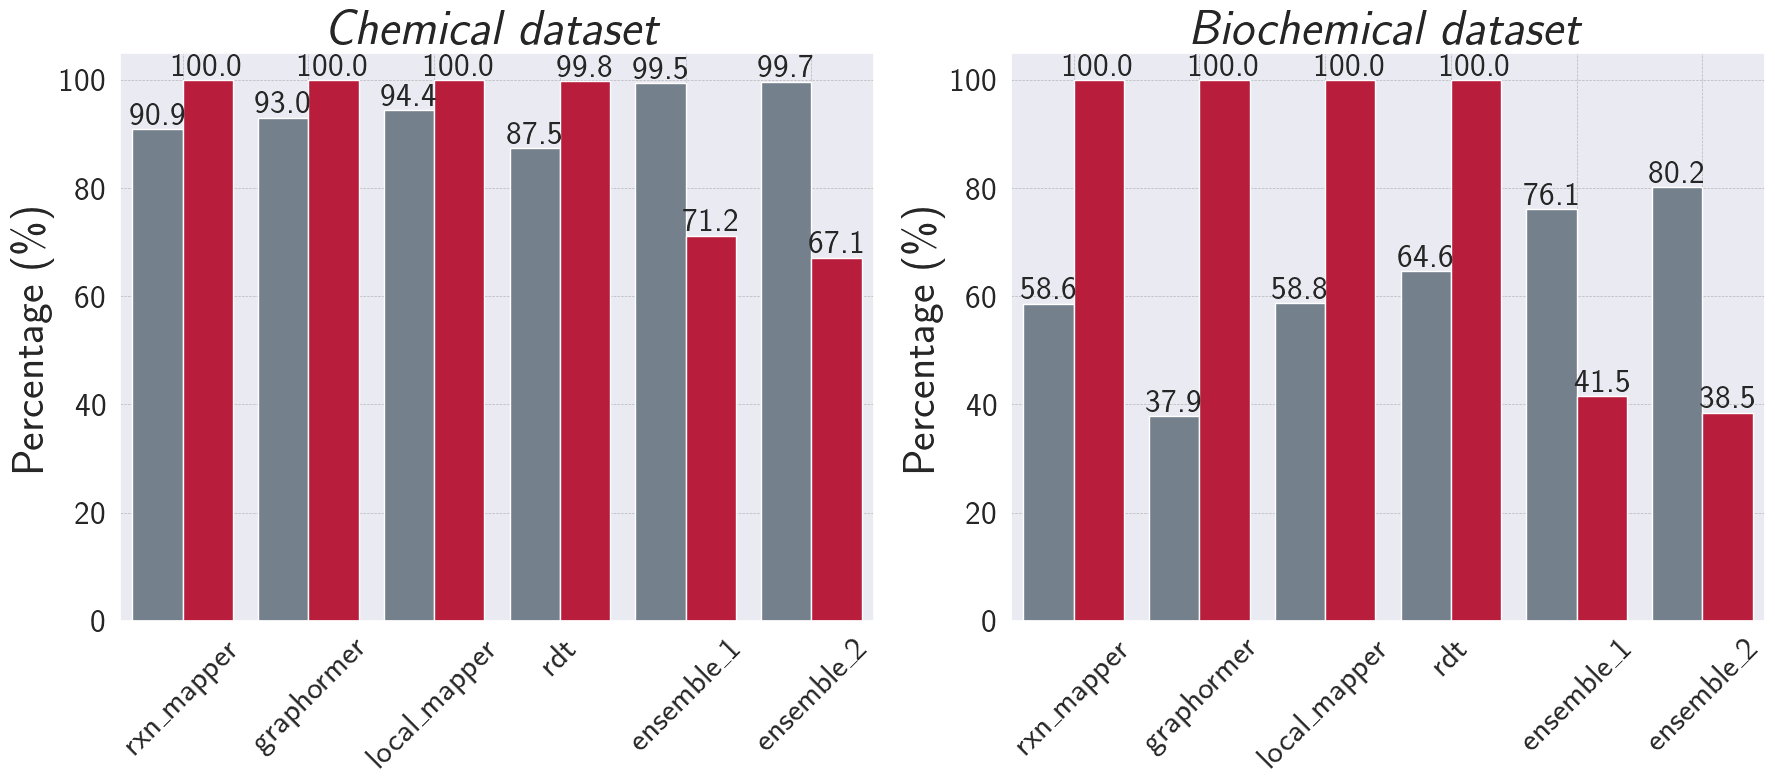

In [7]:
# from _analysis._aam_analysis import plot_accuracy_success_rate_subplot
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{amsmath}")
sns.set_theme(style="darkgrid")

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
plot_accuracy_success_rate_subplot(
    df,
    ["Chemical_accuracy", "Biochemical_accuracy"],
    ["Chemical_success_rate", "Biochemical_success_rate"],
    [r"$\textit{Chemical dataset}$", r"$\textit{Biochemical dataset}$"],
    axes,
)

In [13]:
# Reformatting the provided data into the desired structure

data_cycle = {
    1: [
        {"mapper": "rxn_mapper", "accuracy": 88.25, "success_rate": 100.00},
        {"mapper": "graphormer", "accuracy": 88.15, "success_rate": 100.00},
        {"mapper": "local_mapper", "accuracy": 92.00, "success_rate": 100.00},
        {"mapper": "rdt", "accuracy": 84.96, "success_rate": 99.84},
        {"mapper": "ensemble_1", "accuracy": 98.51, "success_rate": 78.69},
        {"mapper": "ensemble_2", "accuracy": 98.86, "success_rate": 74.24},
    ],
    2: [
        {"mapper": "rxn_mapper", "accuracy": 61.50, "success_rate": 100.00},
        {"mapper": "graphormer", "accuracy": 62.00, "success_rate": 100.00},
        {"mapper": "local_mapper", "accuracy": 60.00, "success_rate": 100.00},
        {"mapper": "rdt", "accuracy": 61.50, "success_rate": 100.00},
        {"mapper": "ensemble_1", "accuracy": 88.46, "success_rate": 39.00},
        {"mapper": "ensemble_2", "accuracy": 95.31, "success_rate": 32.00},
    ],
    3: [
        {"mapper": "rxn_mapper", "accuracy": 44.58, "success_rate": 100.00},
        {"mapper": "graphormer", "accuracy": 53.01, "success_rate": 100.00},
        {"mapper": "local_mapper", "accuracy": 40.96, "success_rate": 100.00},
        {"mapper": "rdt", "accuracy": 43.37, "success_rate": 100.00},
        {"mapper": "ensemble_1", "accuracy": 73.33, "success_rate": 36.14},
        {"mapper": "ensemble_2", "accuracy": 71.43, "success_rate": 33.73},
    ],
}
# Convert this data into a DataFrame:
def create_dataframe(data):
    rows = []
    for bond_changes, entries in data.items():
        for entry in entries:
            entry['steps'] = bond_changes
            rows.append(entry)
    return pd.DataFrame(rows)

df_cycle = create_dataframe(data_cycle)

In [11]:
data = {
    1: [
        {"mapper": "rxn_mapper", "accuracy": 88.73, "success_rate": 100.00},
        {"mapper": "graphormer", "accuracy": 89.01, "success_rate": 100.00},
        {"mapper": "local_mapper", "accuracy": 94.70, "success_rate": 100.00},
        {"mapper": "rdt", "accuracy": 85.85, "success_rate": 99.89},
        {"mapper": "ensemble_1", "accuracy": 99.27, "success_rate": 84.49},
        {"mapper": "ensemble_2", "accuracy": 99.62, "success_rate": 80.36},
    ],
    2: [
        {"mapper": "rxn_mapper", "accuracy": 86.14, "success_rate": 100.00},
        {"mapper": "graphormer", "accuracy": 80.69, "success_rate": 100.00},
        {"mapper": "local_mapper", "accuracy": 84.90, "success_rate": 100.00},
        {"mapper": "rdt", "accuracy": 82.18, "success_rate": 99.75},
        {"mapper": "ensemble_1", "accuracy": 95.77, "success_rate": 76.11},
        {"mapper": "ensemble_2", "accuracy": 96.19, "success_rate": 71.41},
    ],
    3: [
        {"mapper": "rxn_mapper", "accuracy": 62.14, "success_rate": 100.00},
        {"mapper": "graphormer", "accuracy": 61.49, "success_rate": 100.00},
        {"mapper": "local_mapper", "accuracy": 55.99, "success_rate": 100.00},
        {"mapper": "rdt", "accuracy": 61.17, "success_rate": 100.00},
        {"mapper": "ensemble_1", "accuracy": 82.91, "success_rate": 51.13},
        {"mapper": "ensemble_2", "accuracy": 85.51, "success_rate": 44.66},
    ],
    4: [
        {"mapper": "rxn_mapper", "accuracy": 80.56, "success_rate": 100.00},
        {"mapper": "graphormer", "accuracy": 79.17, "success_rate": 100.00},
        {"mapper": "local_mapper", "accuracy": 76.04, "success_rate": 100.00},
        {"mapper": "rdt", "accuracy": 76.39, "success_rate": 99.31},
        {"mapper": "ensemble_1", "accuracy": 94.94, "success_rate": 61.81},
        {"mapper": "ensemble_2", "accuracy": 95.39, "success_rate": 52.78},
    ],
    5: [
        {"mapper": "rxn_mapper", "accuracy": 38.89, "success_rate": 100.00},
        {"mapper": "graphormer", "accuracy": 64.81, "success_rate": 100.00},
        {"mapper": "local_mapper", "accuracy": 55.56, "success_rate": 100.00},
        {"mapper": "rdt", "accuracy": 44.44, "success_rate": 100.00},
        {"mapper": "ensemble_1", "accuracy": 100.00, "success_rate": 29.63},
        {"mapper": "ensemble_2", "accuracy": 100.00, "success_rate": 24.07},
    ],
    6: [
        {"mapper": "rxn_mapper", "accuracy": 55.56, "success_rate": 100.00},
        {"mapper": "graphormer", "accuracy": 66.67, "success_rate": 100.00},
        {"mapper": "local_mapper", "accuracy": 55.56, "success_rate": 100.00},
        {"mapper": "rdt", "accuracy": 74.07, "success_rate": 100.00},
        {"mapper": "ensemble_1", "accuracy": 100.00, "success_rate": 44.44},
        {"mapper": "ensemble_2", "accuracy": 100.00, "success_rate": 44.44},
    ],
    7: [
        {"mapper": "rxn_mapper", "accuracy": 57.14, "success_rate": 100.00},
        {"mapper": "graphormer", "accuracy": 57.14, "success_rate": 100.00},
        {"mapper": "local_mapper", "accuracy": 57.14, "success_rate": 100.00},
        {"mapper": "rdt", "accuracy": 57.14, "success_rate": 100.00},
        {"mapper": "ensemble_1", "accuracy": 100.00, "success_rate": 42.86},
        {"mapper": "ensemble_2", "accuracy": 100.00, "success_rate": 42.86},
    ],
    8: [
        {"mapper": "rxn_mapper", "accuracy": 44.44, "success_rate": 100.00},
        {"mapper": "graphormer", "accuracy": 44.44, "success_rate": 100.00},
        {"mapper": "local_mapper", "accuracy": 11.11, "success_rate": 100.00},
        {"mapper": "rdt", "accuracy": 55.56, "success_rate": 100.00},
        {"mapper": "ensemble_1", "accuracy": 0.00, "success_rate": 11.11},
        {"mapper": "ensemble_2", "accuracy": 0.00, "success_rate": 11.11},
    ],
}

# Convert this data into a DataFrame:
def create_dataframe(data):
    rows = []
    for bond_changes, entries in data.items():
        for entry in entries:
            entry['number_of_bond_changes'] = bond_changes
            rows.append(entry)
    return pd.DataFrame(rows)

df_bond = create_dataframe(data)
print(df_bond)


          mapper  accuracy  success_rate  number_of_bond_changes
0     rxn_mapper     88.73        100.00                       1
1     graphormer     89.01        100.00                       1
2   local_mapper     94.70        100.00                       1
3            rdt     85.85         99.89                       1
4     ensemble_1     99.27         84.49                       1
5     ensemble_2     99.62         80.36                       1
6     rxn_mapper     86.14        100.00                       2
7     graphormer     80.69        100.00                       2
8   local_mapper     84.90        100.00                       2
9            rdt     82.18         99.75                       2
10    ensemble_1     95.77         76.11                       2
11    ensemble_2     96.19         71.41                       2
12    rxn_mapper     62.14        100.00                       3
13    graphormer     61.49        100.00                       3
14  local_mapper     55.9

/tmp/ipykernel_3135595/1061390762.py:306: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_3135595/1061390762.py:309: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(
/tmp/ipykernel_3135595/1061390762.py:306: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_3135595/1061390762.py:309: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


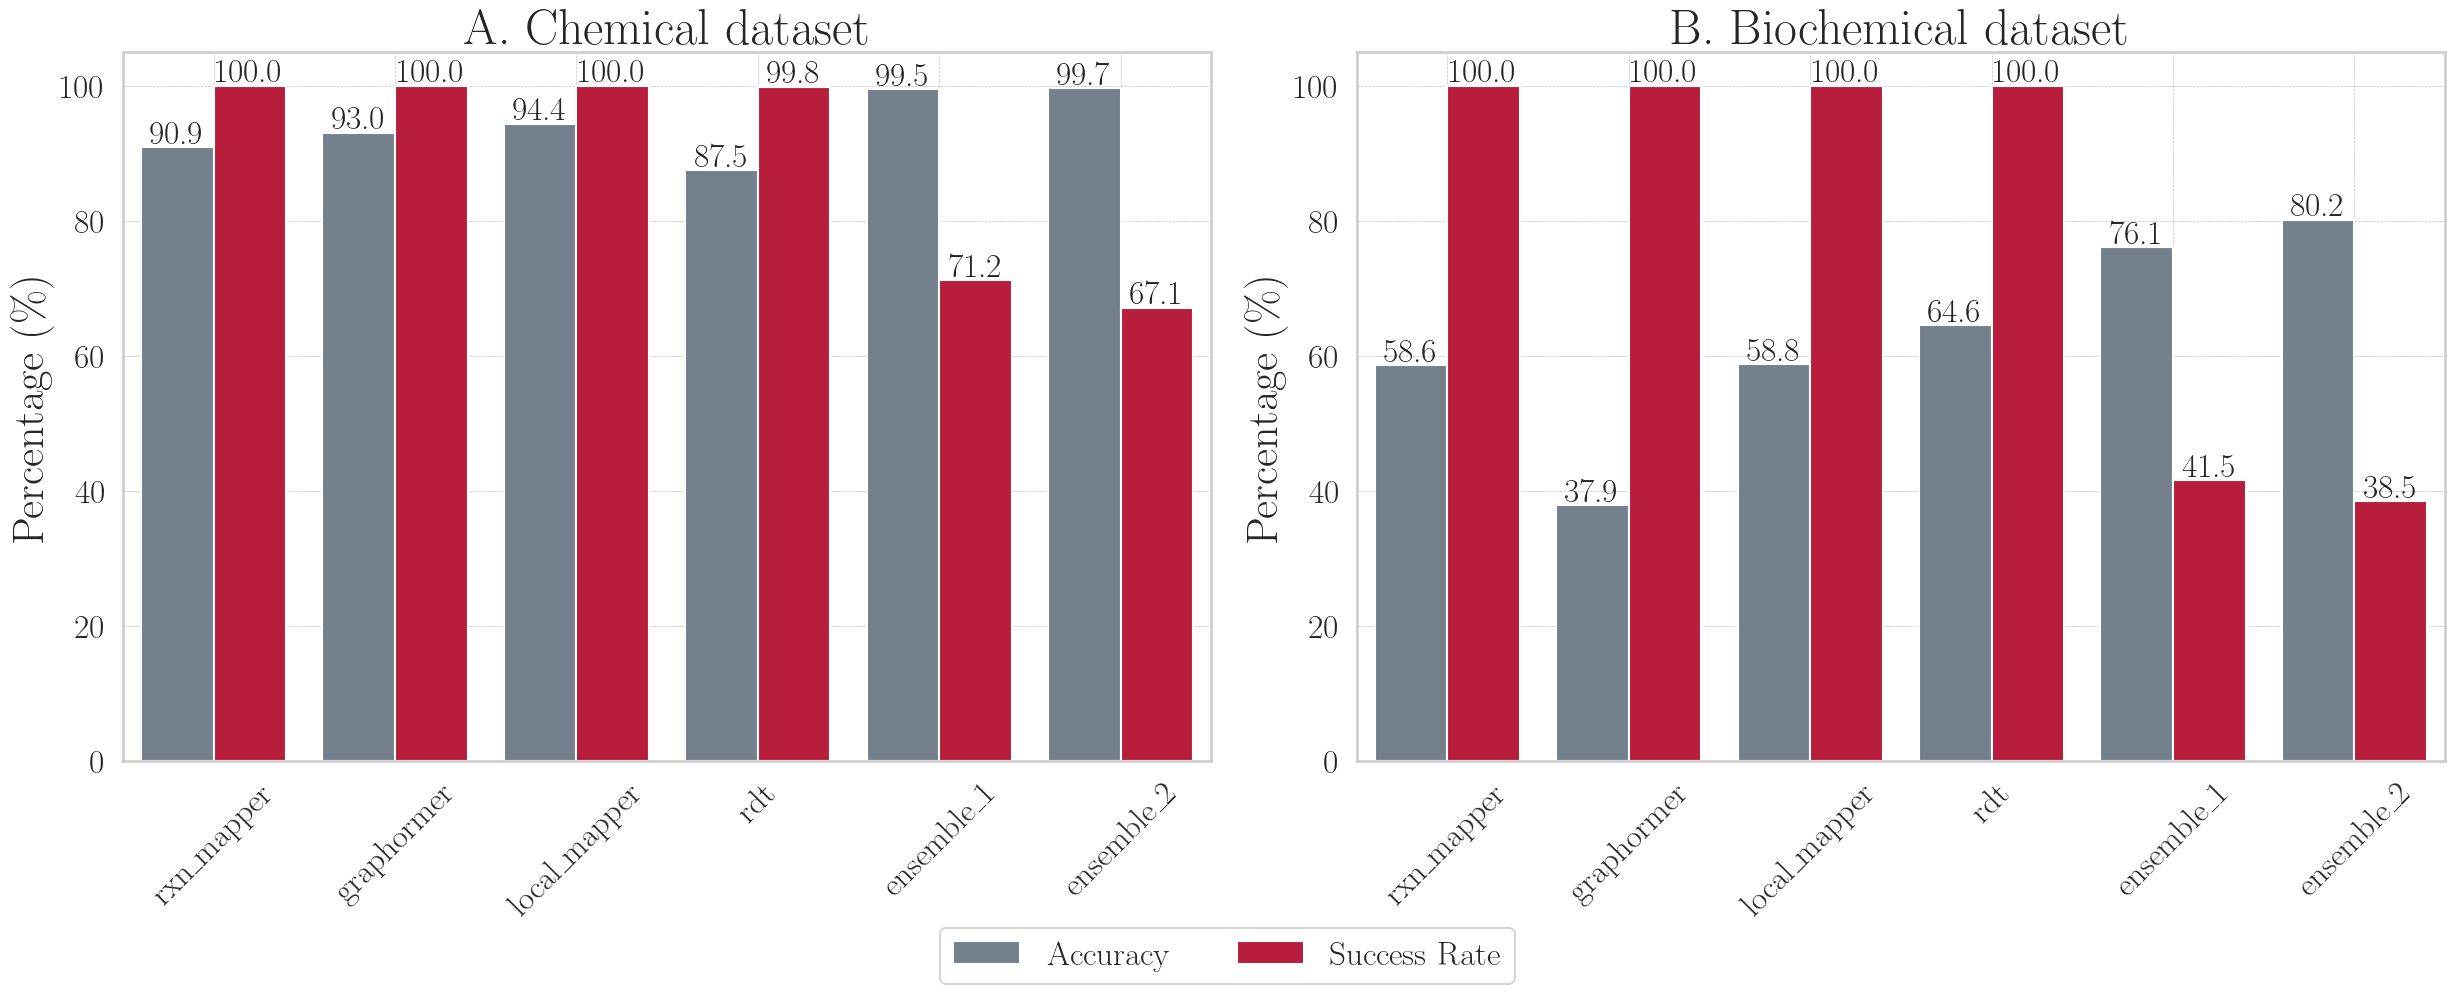

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(25, 8))
plot_accuracy_success_rate_subplot(
    df,
    ["Chemical_accuracy", "Biochemical_accuracy"],
    ["Chemical_success_rate", "Biochemical_success_rate"],
    [r"$\text{A. Chemical dataset}$", r"$\text{B. Biochemical dataset}$"],
    axes,
)
# plt.subplots_adjust(hspace=0.5, wspace=0.5)
# handles, labels = axes[0,1].get_legend_handles_labels()
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.28), 
    ncol=2, fontsize=24, title_fontsize=12, title=None
)

# create_grouped_barplot_with_error(df=df_bond, x='number_of_bond_changes', y='accuracy', hue='mapper', ax=axes[1,0], title='Number of bond changes',  palette=['#66cdaa', '#ff4500', '#ffd700', '#c71585', '#00ff00', '#1e90ff'])
# create_grouped_barplot_with_error(df=df_cycle, x='steps', y='accuracy', hue='mapper', ax=axes[1,1], title='Number of cycles in reaction center',  palette=['#66cdaa', '#ff4500', '#ffd700', '#c71585', '#00ff00', '#1e90ff'])


# # "#66cdaa”, “#ff4500”, “#ffd700”, “#c71585”, “#00ff00”, “#1e90ff"
# # Add a single legend for all plots
# handles, labels = axes[1,1].get_legend_handles_labels()
# fig.legend(
#     handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.07), 
#     ncol=6, fontsize=24, title_fontsize=12, title=None
# )

# Adjust layout for better spacing
plt.tight_layout()
plt.subplots_adjust(bottom=0.02)  # Adjust space for legend below the plots
plt.savefig(
    "./fig/Fig6_half_1.pdf", dpi=600, bbox_inches="tight", pad_inches=0
)
plt.show()


/tmp/ipykernel_3135595/93857233.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_3135595/93857233.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


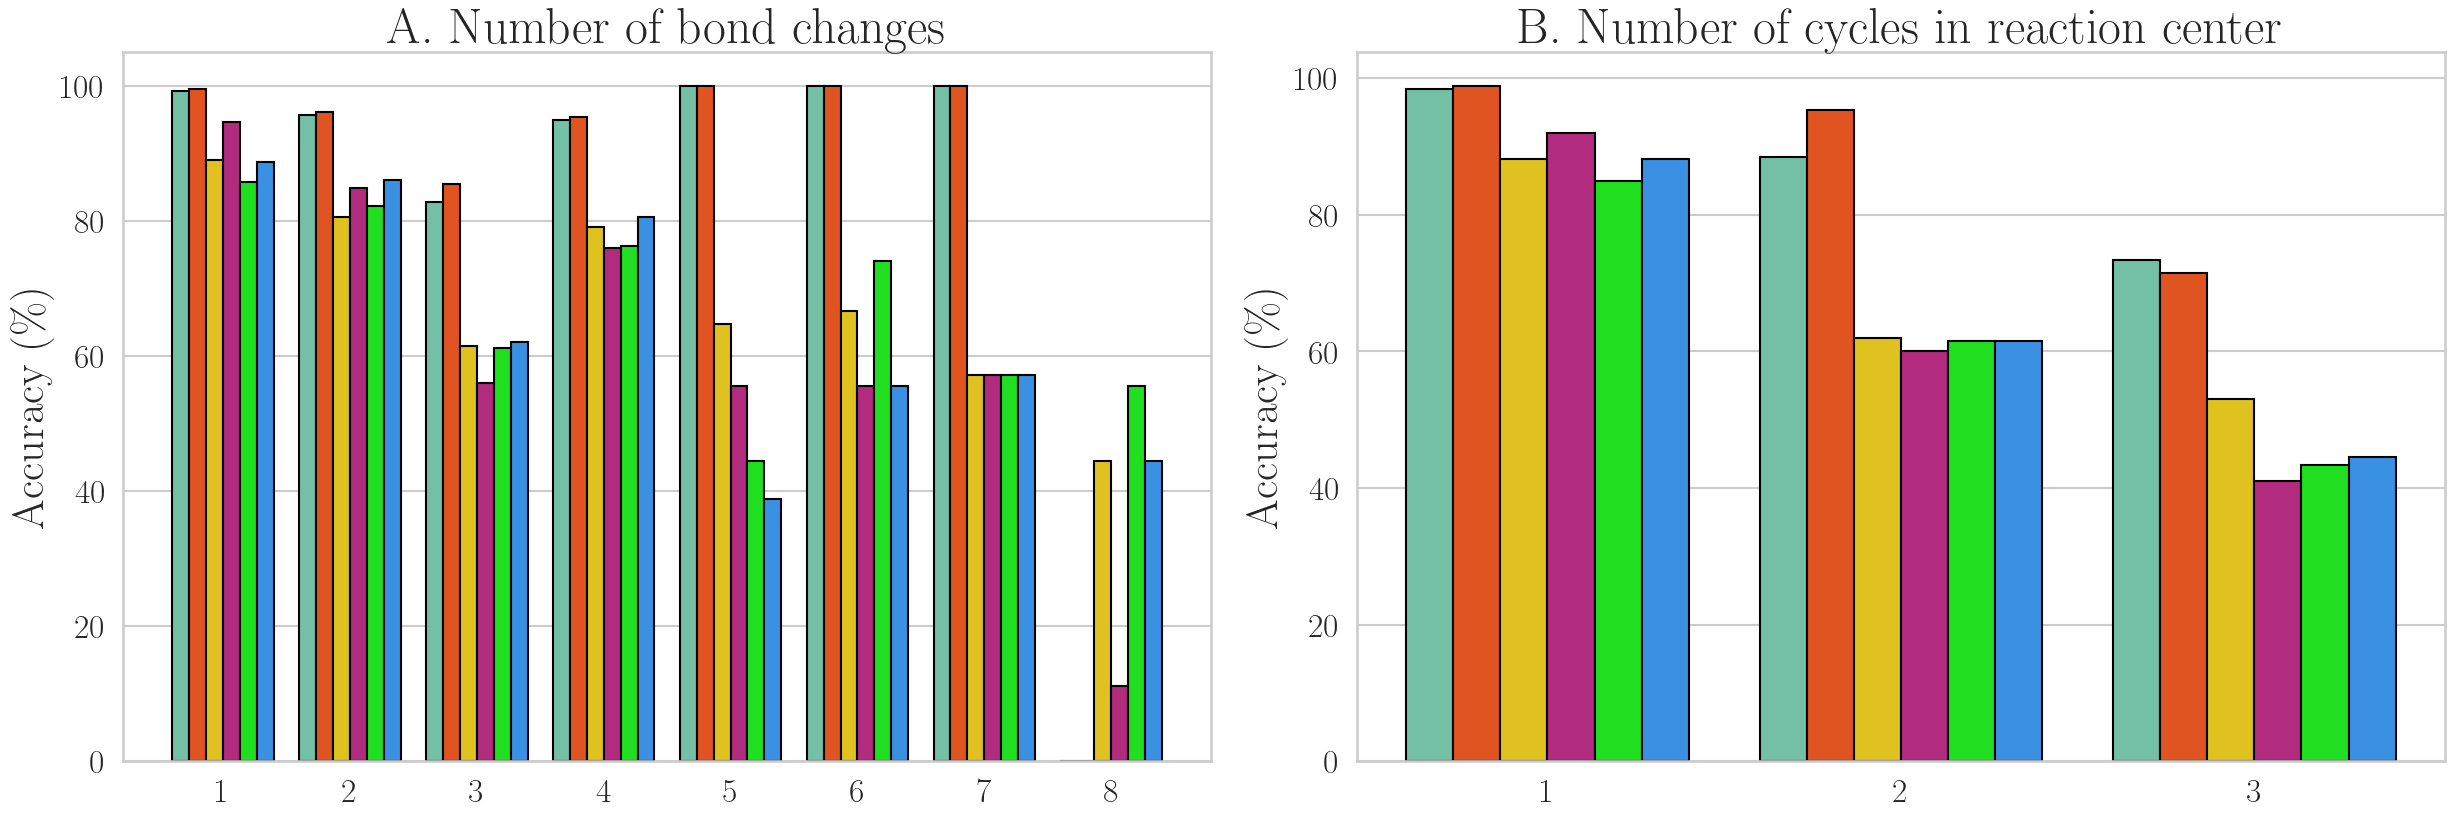

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(25, 8))
# plot_accuracy_success_rate_subplot(
#     df,
#     ["Chemical_accuracy", "Biochemical_accuracy"],
#     ["Chemical_success_rate", "Biochemical_success_rate"],
#     [r"$\text{A. Chemical dataset}$", r"$\text{B. Biochemical dataset}$"],
#     axes,
# )
# # plt.subplots_adjust(hspace=0.5, wspace=0.5)
# # handles, labels = axes[0,1].get_legend_handles_labels()
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(
#     handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.28), 
#     ncol=2, fontsize=24, title_fontsize=12, title=None
# )

create_grouped_barplot_with_error(df=df_bond, x='number_of_bond_changes', y='accuracy', hue='mapper', ax=axes[0], title='A. Number of bond changes',  palette=['#66cdaa', '#ff4500', '#ffd700', '#c71585', '#00ff00', '#1e90ff'])
create_grouped_barplot_with_error(df=df_cycle, x='steps', y='accuracy', hue='mapper', ax=axes[1], title='B. Number of cycles in reaction center',  palette=['#66cdaa', '#ff4500', '#ffd700', '#c71585', '#00ff00', '#1e90ff'])


# # "#66cdaa”, “#ff4500”, “#ffd700”, “#c71585”, “#00ff00”, “#1e90ff"
# # Add a single legend for all plots
# handles, labels = axes[1,1].get_legend_handles_labels()
# fig.legend(
#     handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.07), 
#     ncol=6, fontsize=24, title_fontsize=12, title=None
# )

# Adjust layout for better spacing
plt.tight_layout()
plt.subplots_adjust(bottom=0.02)  # Adjust space for legend below the plots
plt.savefig(
    "./fig/Fig6_half_2.pdf", dpi=600, bbox_inches="tight", pad_inches=0
)
plt.show()


In [24]:
axes.get_legend_handles_labels()

AttributeError: 'numpy.ndarray' object has no attribute 'get_legend_handles_labels'

In [27]:
axes[0].get_legend_handles_labels()

([<matplotlib.patches.Rectangle at 0x7fcc9483f8d0>,
 ['Accuracy', 'Success Rate'])

/tmp/ipykernel_3135595/1061390762.py:306: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_3135595/1061390762.py:309: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(
/tmp/ipykernel_3135595/1061390762.py:306: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_3135595/1061390762.py:309: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


/tmp/ipykernel_3135595/93857233.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_3135595/93857233.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


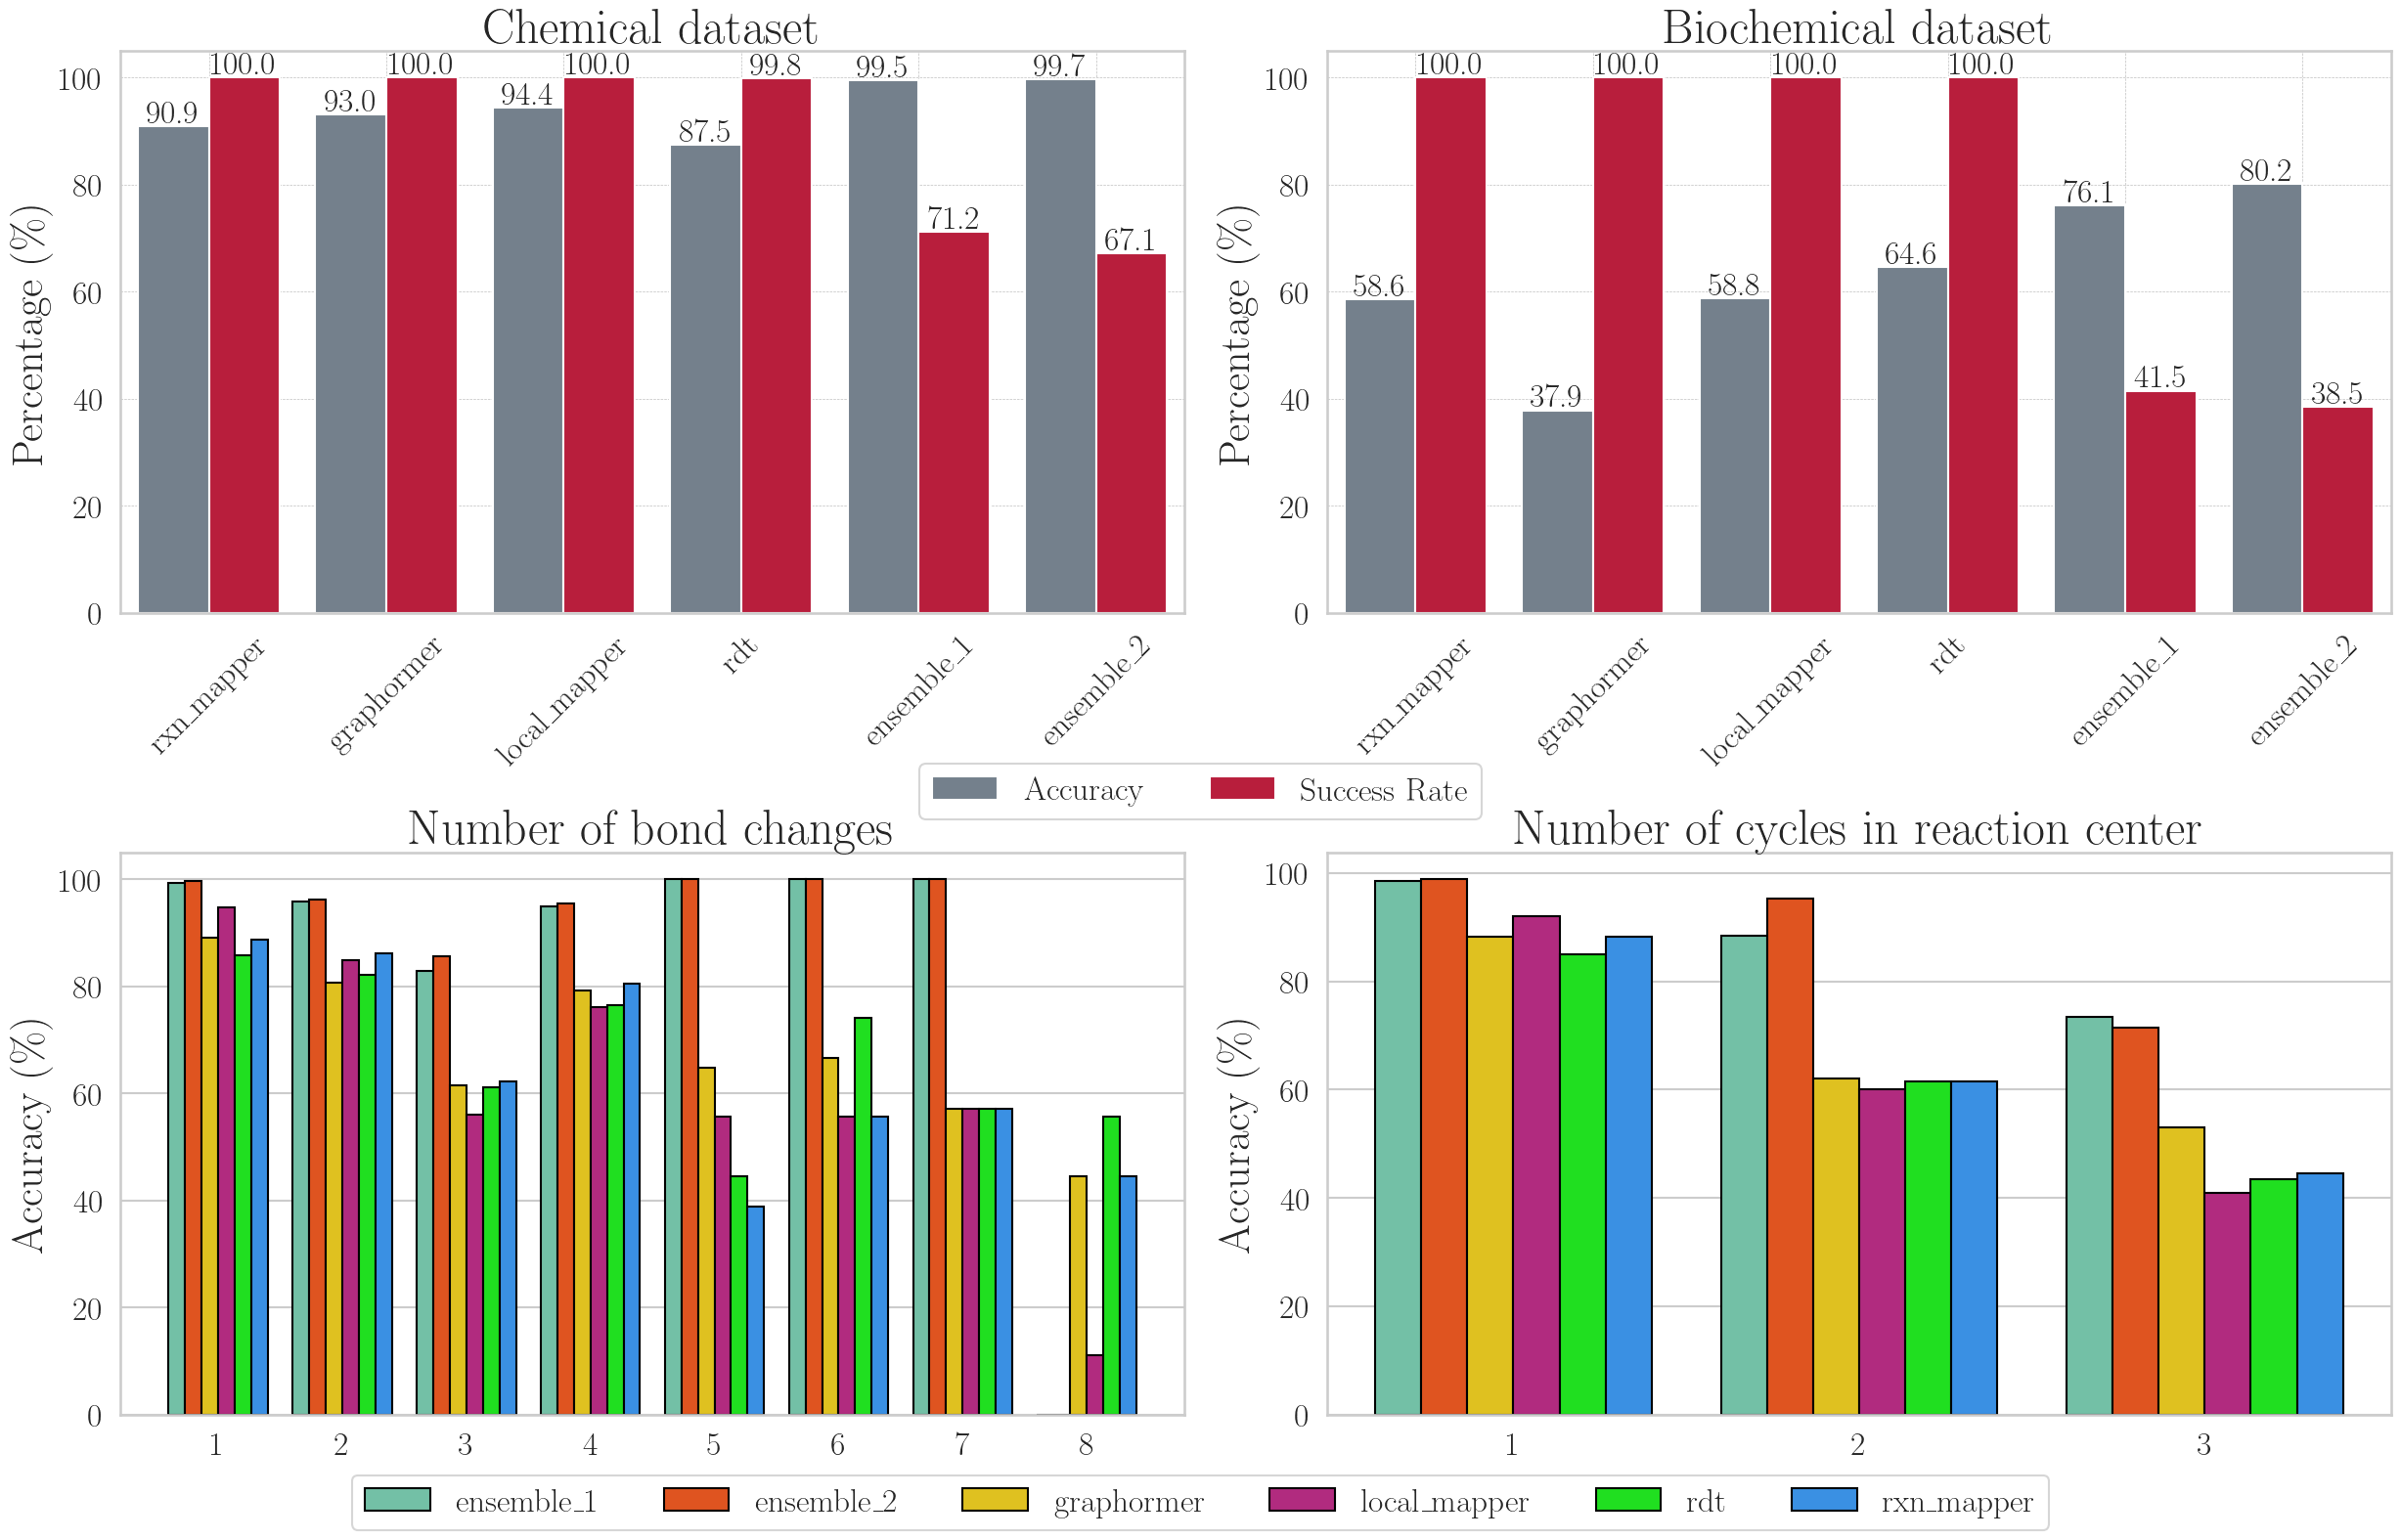

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(25, 15))
plot_accuracy_success_rate_subplot(
    df,
    ["Chemical_accuracy", "Biochemical_accuracy"],
    ["Chemical_success_rate", "Biochemical_success_rate"],
    [r"$\text{Chemical dataset}$", r"$\text{Biochemical dataset}$"],
    axes[0,:],
)
plt.subplots_adjust(hspace=0.5, wspace=0.5)
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(
    handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.415), 
    ncol=2, fontsize=24, title_fontsize=12, title=None
)

create_grouped_barplot_with_error(df=df_bond, x='number_of_bond_changes', y='accuracy', hue='mapper', ax=axes[1,0], title='Number of bond changes',  palette=['#66cdaa', '#ff4500', '#ffd700', '#c71585', '#00ff00', '#1e90ff'])
create_grouped_barplot_with_error(df=df_cycle, x='steps', y='accuracy', hue='mapper', ax=axes[1,1], title='Number of cycles in reaction center',  palette=['#66cdaa', '#ff4500', '#ffd700', '#c71585', '#00ff00', '#1e90ff'])


# "#66cdaa”, “#ff4500”, “#ffd700”, “#c71585”, “#00ff00”, “#1e90ff"
# Add a single legend for all plots
handles, labels = axes[1,1].get_legend_handles_labels()
fig.legend(
    handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.07), 
    ncol=6, fontsize=24, title_fontsize=12, title=None
)

# Adjust layout for better spacing
plt.tight_layout()
plt.subplots_adjust(bottom=0.02)  # Adjust space for legend below the plots
plt.savefig(
    "./fig/Fig6_new.pdf", dpi=600, bbox_inches="tight", pad_inches=0
)
plt.show()


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
def create_grouped_barplot_with_error(df, x, y, hue, ax=None, title='', xlabel='', ylabel=r'Accuracy (\%)', palette=None):
    # Set the aesthetic style
    sns.set(style="whitegrid", context='talk', font='serif', font_scale=1.2)
    plt.rcParams['font.family'] = 'serif'
    
    # Extend palette to include six colors
    palette = sns.color_palette(palette, n_colors=6) if palette else sns.color_palette("tab10", n_colors=6)
    
    # Aggregate data to calculate means and standard deviations for error bars
    summary = df.groupby([x, hue])[y].agg(['mean', 'std']).reset_index()
    summary.rename(columns={'mean': y, 'std': 'std_dev'}, inplace=True)

    # Use the provided axis or create a new one
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create the barplot
    sns.barplot(
        x=x, y=y, hue=hue, data=summary, 
        palette=palette, ci=None, edgecolor='black', ax=ax
    )
    
    # Add error bars
    for i, bar in enumerate(ax.patches):
        # Get the x-coordinate, width, and height of each bar
        x_val = bar.get_x() + bar.get_width() / 2
        height = bar.get_height()
        
        # Extract standard deviation for this bar
        idx = i // len(summary[hue].unique())
        hue_group = i % len(summary[hue].unique())
        std_dev = summary.iloc[idx]['std_dev']
        
        # Plot error bars
        ax.errorbar(x=x_val, y=height, yerr=std_dev, color='black', capsize=5, fmt='none')

    # Set title and y-axis label
    ax.set_title(title, fontsize=36, weight='bold')
    ax.set_ylabel(ylabel, fontsize=32)
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
    
    # Set x-axis label at the top
    ax.xaxis.set_label_position('top')  # Set x-axis label position to the top
    ax.set_xlabel(xlabel, fontsize=24, labelpad=20)  # Add padding to position label above

    # Do not include legend here; it will be added at the figure level
    ax.get_legend().remove()





In [ ]:
from _analysis._aam_analysis import (
    plot_accuracy_success_rate_subplot,
    # plot_reaction_times,
)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


accuracy_cols = ["Chemical_accuracy", "Biochemical_accuracy"]
success_cols = ["Chemical_success_rate", "Biochemical_success_rate"]
titles = [r"$\textit{B. Chemical dataset}$", r"$\textit{C. Biochemical dataset}$"]

df = final_df.copy()
df["mapper"] = [
    r"$\texttt{RXNMapper}$",
    r"$\texttt{GraphormerMapper}$",
    r"$\texttt{LocalMapper}$",
    r"$\texttt{RDT}$",
    r"$\textit{Ensemble_1}$",
    r"$\textit{Ensemble_2}$",
]

# Create a 2x2 subplot layout
fig = plt.figure(figsize=(18, 16))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])

# First row: reaction times plot (spans the entire width)
ax0 = plt.subplot(gs[0, :])
plot_reaction_times(df_time, ax0)

# Second row: accuracy and success rate subplots
ax1 = plt.subplot(gs[1, 0])
ax2 = plt.subplot(gs[1, 1])
plot_accuracy_success_rate_subplot(df, accuracy_cols, success_cols, titles, [ax1, ax2])

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the combined plot
fig.savefig(
    "./fig/Fig6_aam_time_data_benchmark.pdf", dpi=600, bbox_inches="tight", pad_inches=0
)
plt.show()